###### 10/11に選定したringデータを使用
###### 使用ランクは、3,4,5

## これを使用して、deepclusterで学習したパラメーターを転移した。
### deepclusterのパラメータは、2022/1/24に学習した最初のdeepcluster

In [1]:
import pandas as pd
from math import sqrt as sqrt
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function
from torchsummary import summary
import torch.utils.data as data
import torch.optim as optim

import ast
import cv2
import numpy as np
import time
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
# import sys
# sys.path.append('../')
from utils.ssd_model import SSD
from utils.ssd_model import MultiBoxLoss
from utils.ssd_model import decode

In [3]:
# class EarlyStopping:
#     """Early stops the training if validation loss doesn't improve after a given patience."""
#     def __init__(self, path, patience=7, verbose=False, delta=0, trace_func=print):
#         """
#         Args:
#             patience (int): How long to wait after last time validation loss improved.
#                             Default: 7
#             verbose (bool): If True, prints a message for each validation loss improvement. 
#                             Default: False
#             delta (float): Minimum change in the monitored quantity to qualify as an improvement.
#                             Default: 0
#             path (str): Path for the checkpoint to be saved to.
#                             Default: 'checkpoint.pt'
#             trace_func (function): trace print function.
#                             Default: print            
#         """
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.f1_score_max = -np.Inf
#         self.delta = delta
#         self.path = path
#         self.trace_func = trace_func
#     def __call__(self, f1_score, model):

#         score = f1_score

#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(f1_score, model)
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(f1_score, model)
#             self.counter = 0

#     def save_checkpoint(self, f1_score, model):
#         '''Saves model when f1_score increase.'''
#         if self.verbose:
#             self.trace_func(f'f1_score increase ({self.f1_score_max:.6f} --> {f1_score:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), self.path)
#         self.f1_score_max = f1_score

In [4]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, path, patience=7, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [5]:
input_size = 300
color_mean = (0, 0)
voc_classes = ['ring']

In [6]:
ssd_cfg = {
    'num_classes': 2,  # 背景クラスを含めた合計クラス数
    'input_size': input_size,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
#     'bbox_aspect_num': [4, 4, 4, 4, 4, 4],
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ   
#     'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2,3], [2,3], [2,3], [2], [2]],
}

In [7]:
train_label = pd.read_csv('../../../data_for_ssd/MWP_data/ring_selection_for_ssd/new_sentei_data_10_11/train_val_data/train_label.csv')
train_data = np.load('../../../data_for_ssd/MWP_data/ring_selection_for_ssd/new_sentei_data_10_11/train_val_data/train.npy')
val_label = pd.read_csv('../../../data_for_ssd/MWP_data/ring_selection_for_ssd/new_sentei_data_10_11/train_val_data/val_label.csv')
val_data = np.load('../../../data_for_ssd/MWP_data/ring_selection_for_ssd/new_sentei_data_10_11/train_val_data/val.npy')

train_data = train_data[:,:,:,:2]
train_data = np.swapaxes(train_data, 2, 3)
train_data = np.swapaxes(train_data, 1, 2)

val_data = val_data[:,:,:,:2]
val_data = np.swapaxes(val_data, 2, 3)
val_data = np.swapaxes(val_data, 1, 2)

In [8]:
print(len(train_label),train_data.shape)
print(len(val_label),val_data.shape)

18729 (18729, 2, 300, 300)
702 (702, 2, 300, 300)


In [9]:
train_label = train_label.drop('Unnamed: 0', axis=1)
val_label = val_label.drop('Unnamed: 0', axis=1)
# label = label.drop('index', axis=1)

In [10]:
train_label['xmin'] = [ast.literal_eval(d) for d in train_label['xmin']]
train_label['xmax'] = [ast.literal_eval(d) for d in train_label['xmax']]
train_label['ymin'] = [ast.literal_eval(d) for d in train_label['ymin']]
train_label['ymax'] = [ast.literal_eval(d) for d in train_label['ymax']]

val_label['xmin'] = [ast.literal_eval(d) for d in val_label['xmin']]
val_label['xmax'] = [ast.literal_eval(d) for d in val_label['xmax']]
val_label['ymin'] = [ast.literal_eval(d) for d in val_label['ymin']]
val_label['ymax'] = [ast.literal_eval(d) for d in val_label['ymax']]

In [11]:
train_label = train_label.reset_index()
val_label = val_label.reset_index()

In [12]:
train_label_list = []
for i in range(len(train_label)):
    lab = []
    for k in range(len(train_label['xmin'][i])):
        labe = []
        labe.append(train_label['xmin'][i][k])
        labe.append(train_label['ymin'][i][k])
        labe.append(train_label['xmax'][i][k])
        labe.append(train_label['ymax'][i][k])
        labe.append(0)
        lab.append(labe)
    train_label_list.append(np.array(lab))

val_label_list = []
for i in range(len(val_label)):
    lab = []
    for k in range(len(val_label['xmin'][i])):
        labe = []
        labe.append(val_label['xmin'][i][k])
        labe.append(val_label['ymin'][i][k])
        labe.append(val_label['xmax'][i][k])
        labe.append(val_label['ymax'][i][k])
        labe.append(0)
        lab.append(labe)
    val_label_list.append(np.array(lab))

In [13]:
val_label_list[1].shape, val_label_list[-1].shape

((1, 5), (0,))

In [14]:
print(len(train_label_list), len(val_label_list))

18729 702


In [15]:
train_data.shape, val_data.shape

((18729, 2, 300, 300), (702, 2, 300, 300))

In [16]:
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
    imgs = torch.stack(imgs, dim=0)
        
    return imgs, targets

In [17]:
# for d in train_data_list[0]:
#     if sum(np.isnan(d.ravel())) == 0:
#         pass
#     else:
#         print('neko')

In [18]:
class DataSet():
    def __init__(self, data, label):
        self.label = label
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [19]:
class NegativeSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, source, true_size, sample_negative_size):
        self.true_size = true_size
        self.negative_size = len(source) - true_size
        self.sample_negative_size = sample_negative_size
    def __iter__(self):
        neg = np.arange(self.true_size, self.true_size + self.sample_negative_size)
        indeces = np.concatenate((np.arange(self.true_size), np.random.choice(neg, self.sample_negative_size)))
        np.random.shuffle(indeces)
        for i in indeces:
            yield i
    def __len__(self):
        return self.true_size + self.sample_negative_size

In [20]:
train_sampler = NegativeSampler(train_data, true_size=12729, sample_negative_size=3591)
val_sampler = NegativeSampler(val_data, true_size=252, sample_negative_size=292)
batch_size = 32

In [21]:
train_dataset = DataSet(torch.Tensor(train_data), train_label_list)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=od_collate_fn)

test_dataset = DataSet(torch.Tensor(val_data), val_label_list)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=val_sampler, collate_fn=od_collate_fn)

In [22]:
dataloaders_dict = {"train": train_loader, "val": test_loader}

In [23]:
net = SSD(phase='train', cfg=ssd_cfg)
# CNN_weight = torch.load('ssd300_mAP_77.43_v2.pth')

In [24]:
net

SSD(
  (vgg): ModuleList(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stri

In [25]:
deepcluster_weight = torch.load('checkpoint.pth.tar')

In [26]:
net.vgg[0].weight = nn.Parameter(deepcluster_weight['state_dict']['features.0.weight'])
net.vgg[0].bias = nn.Parameter(deepcluster_weight['state_dict']['features.0.bias'])

net.vgg[2][0].weight = nn.Parameter(deepcluster_weight['state_dict']['features.2.0.weight'])
net.vgg[2][0].bias = nn.Parameter(deepcluster_weight['state_dict']['features.2.0.bias'])
net.vgg[2][0].running_mean = deepcluster_weight['state_dict']['features.2.0.running_mean'].to('cpu')
net.vgg[2][0].running_var = deepcluster_weight['state_dict']['features.2.0.running_var'].to('cpu')
net.vgg[2][0].num_batches_tracked = deepcluster_weight['state_dict']['features.2.0.num_batches_tracked'].to('cpu')
net.vgg[2][1].weight = nn.Parameter(deepcluster_weight['state_dict']['features.2.1.weight'])
net.vgg[2][1].bias = nn.Parameter(deepcluster_weight['state_dict']['features.2.1.bias'])

net.vgg[5].weight = nn.Parameter(deepcluster_weight['state_dict']['features.5.weight'])
net.vgg[5].bias = nn.Parameter(deepcluster_weight['state_dict']['features.5.bias'])

# net.vgg[7][0].weight = nn.Parameter(deepcluster_weight['state_dict']['features.7.0.weight'])
# net.vgg[7][0].bias = nn.Parameter(deepcluster_weight['state_dict']['features.7.0.bias'])
# net.vgg[7][0].running_mean = deepcluster_weight['state_dict']['features.7.0.running_mean'].to('cpu')
# net.vgg[7][0].running_var = deepcluster_weight['state_dict']['features.7.0.running_var'].to('cpu')
# net.vgg[7][0].num_batches_tracked = deepcluster_weight['state_dict']['features.7.0.num_batches_tracked'].to('cpu')
# net.vgg[7][1].weight = nn.Parameter(deepcluster_weight['state_dict']['features.7.1.weight'])
# net.vgg[7][1].bias = nn.Parameter(deepcluster_weight['state_dict']['features.7.1.bias'])
net.vgg[7].weight = nn.Parameter(deepcluster_weight['state_dict']['features.7.1.weight'])
net.vgg[7].bias = nn.Parameter(deepcluster_weight['state_dict']['features.7.1.bias'])

net.vgg[10].weight = nn.Parameter(deepcluster_weight['state_dict']['features.10.weight'])
net.vgg[10].bias = nn.Parameter(deepcluster_weight['state_dict']['features.10.bias'])

# net.vgg[12][0].weight = nn.Parameter(deepcluster_weight['state_dict']['features.12.0.weight'])
# net.vgg[12][0].bias = nn.Parameter(deepcluster_weight['state_dict']['features.12.0.bias'])
# net.vgg[12][0].running_mean = deepcluster_weight['state_dict']['features.12.0.running_mean'].to('cpu')
# net.vgg[12][0].running_var = deepcluster_weight['state_dict']['features.12.0.running_var'].to('cpu')
# net.vgg[12][0].num_batches_tracked = deepcluster_weight['state_dict']['features.12.0.num_batches_tracked'].to('cpu')
# net.vgg[12][1].weight = nn.Parameter(deepcluster_weight['state_dict']['features.12.1.weight'])
# net.vgg[12][1].bias = nn.Parameter(deepcluster_weight['state_dict']['features.12.1.bias'])
net.vgg[12].weight = nn.Parameter(deepcluster_weight['state_dict']['features.12.1.weight'])
net.vgg[12].bias = nn.Parameter(deepcluster_weight['state_dict']['features.12.1.bias'])

net.vgg[17].weight = nn.Parameter(deepcluster_weight['state_dict']['features.17.weight'])
net.vgg[17].bias = nn.Parameter(deepcluster_weight['state_dict']['features.17.bias'])

# net.vgg[19][0].weight = nn.Parameter(deepcluster_weight['state_dict']['features.19.0.weight'])
# net.vgg[19][0].bias = nn.Parameter(deepcluster_weight['state_dict']['features.19.0.bias'])
# net.vgg[19][0].running_mean = deepcluster_weight['state_dict']['features.19.0.running_mean'].to('cpu')
# net.vgg[19][0].running_var = deepcluster_weight['state_dict']['features.19.0.running_var'].to('cpu')
# net.vgg[19][0].num_batches_tracked = deepcluster_weight['state_dict']['features.19.0.num_batches_tracked'].to('cpu')
net.vgg[19].weight = nn.Parameter(deepcluster_weight['state_dict']['features.19.1.weight'])
net.vgg[19].bias = nn.Parameter(deepcluster_weight['state_dict']['features.19.1.bias'])

net.vgg[21].weight = nn.Parameter(deepcluster_weight['state_dict']['features.21.weight'])
net.vgg[21].bias = nn.Parameter(deepcluster_weight['state_dict']['features.21.bias'])

net.vgg[24].weight = nn.Parameter(deepcluster_weight['state_dict']['features.24.weight'])
net.vgg[24].bias = nn.Parameter(deepcluster_weight['state_dict']['features.24.bias'])

# net.vgg[26][0].weight = nn.Parameter(deepcluster_weight['state_dict']['features.26.0.weight'])
# net.vgg[26][0].bias = nn.Parameter(deepcluster_weight['state_dict']['features.26.0.bias'])
# net.vgg[26][0].running_mean = deepcluster_weight['state_dict']['features.26.0.running_mean'].to('cpu')
# net.vgg[26][0].running_var = deepcluster_weight['state_dict']['features.26.0.running_var'].to('cpu')
# net.vgg[26][0].num_batches_tracked = deepcluster_weight['state_dict']['features.26.0.num_batches_tracked'].to('cpu')
net.vgg[26].weight = nn.Parameter(deepcluster_weight['state_dict']['features.26.1.weight'])
net.vgg[26].bias = nn.Parameter(deepcluster_weight['state_dict']['features.26.1.bias'])

net.vgg[28].weight = nn.Parameter(deepcluster_weight['state_dict']['features.28.weight'])
net.vgg[28].bias = nn.Parameter(deepcluster_weight['state_dict']['features.28.bias'])

net.vgg[31].weight = nn.Parameter(deepcluster_weight['state_dict']['features.31.weight'])
net.vgg[31].bias = nn.Parameter(deepcluster_weight['state_dict']['features.31.bias'])

net.vgg[33].weight = nn.Parameter(deepcluster_weight['state_dict']['features.33.weight'])
net.vgg[33].bias = nn.Parameter(deepcluster_weight['state_dict']['features.33.bias'])

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stri

In [28]:
summary(net, (2, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 300, 300]             608
              ReLU-2         [-1, 32, 300, 300]               0
       BatchNorm2d-3         [-1, 32, 300, 300]              64
            Conv2d-4         [-1, 32, 300, 300]           9,248
              ReLU-5         [-1, 32, 300, 300]               0
         MaxPool2d-6         [-1, 32, 150, 150]               0
            Conv2d-7         [-1, 64, 150, 150]          18,496
              ReLU-8         [-1, 64, 150, 150]               0
            Conv2d-9         [-1, 64, 150, 150]          36,928
             ReLU-10         [-1, 64, 150, 150]               0
        MaxPool2d-11           [-1, 64, 75, 75]               0
           Conv2d-12          [-1, 128, 75, 75]          73,856
             ReLU-13          [-1, 128, 75, 75]               0
           Conv2d-14          [-1, 128,

In [29]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [30]:
# net.vgg.apply(weights_init)
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

ModuleList(
  (0): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 8, kernel_size=(1, 1), stride=(1, 1))
)

In [31]:
# for i in net.parameters():
#     print(i.requires_grad)

<function matplotlib.pyplot.show(close=None, block=None)>

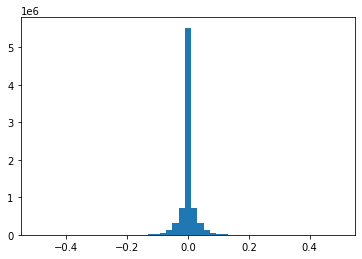

In [32]:
list_ = []
for i in net.parameters():
    i = i.to('cpu').detach().numpy().ravel()
    list_.append(i)
    pass

list_ = np.concatenate(list_)
plt.hist(list_, bins=np.linspace(-0.5, 0.5, 50))
plt.show

In [33]:
criterion = MultiBoxLoss(jaccard_thresh=0.45, neg_pos=2, device=device)
# optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
optimizer = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
# optimizer = optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [34]:
# ll , boxは一枚の画像に対する、正解と予想
def calc_collision(ll, box):
    if len(ll) == 0:
        return None,  box[:,0]
    else:
        true_positive = []
        for l in ll:
            cx = (l[0]+l[2])/2
            cy = (l[1]+l[3])/2

            # np.logi~~で、どのボックスが正解の中心を含んでいるのかを出している。
            true_positive.append(np.logical_and.reduce((box[:,1]<=cx, box[:,3]>=cx, box[:,2]<=cy, box[:,4]>=cy)))
    
        return np.stack(true_positive), box[:,0]#, ll[:,2]-ll[:,0]#, true_positive
    


In [35]:
def calc_f1score(val_seikai, val_bbbb):
    collisions = [calc_collision(s,b) for s,b in zip(val_seikai, val_bbbb)]
    thresholds = [ i/10000 for i in range(0, 10000, 1)]

    f1_score = -10000

    for th in thresholds:
        TP1 = 0
        TP2 = 0
        TP1_FP = 0
        TP2_FN = 0

        for col,prob in collisions:
            idx = prob > th
            tp1_fp = idx.sum()
            TP1_FP += tp1_fp

            if col is not None:
                tp1 = col[:,idx].any(axis=0) # for tp1
                tp2 = col[:,idx].any(axis=1) # for tp2
                tp2_fn = col.shape[0]
                TP1 += np.sum(tp1)
                TP2 += np.sum(tp2)
                TP2_FN += tp2_fn 

        f1_score_ = 2*(TP1/TP1_FP)*(TP2/TP2_FN)/(TP1/TP1_FP+TP2/TP2_FN) 

        if f1_score_>f1_score:
            f1_score = f1_score_

    
    return f1_score

In [36]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, file_name):
    loss_l_list_val = []
    loss_c_list_val = []
    loss_c_nega_list_val = []
    loss_c_posi_list_val = []
    
    loss_l_list_train = []
    loss_c_list_train = []
    loss_c_nega_list_train = []
    loss_c_posi_list_train = [] 
    
    softmax = nn.Softmax(dim=-1)
    tempo_val_loss = 100000000000000
    # GPUが使えるかを確認
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    early_stopping = EarlyStopping(patience=10, verbose=True, path='earlystopping.pth')
    # イテレーションカウンタをセット
    logs = []

    # epochのループ
    for epoch in range(num_epochs):
        iteration = 0
        val_iter = 0
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和
 
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        train_bbbb = []
        train_seikai = []
        val_bbbb = []
        val_seikai = []
        loss_ll_val = 0
        loss_cc_val = 0
        loss_c_posii_val = 0
        loss_c_negaa_val = 0
        loss_ll_train = 0
        loss_cc_train = 0
        loss_c_posii_train = 0
        loss_c_negaa_train = 0
        
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                net.eval()
    
            for images, targets in dataloaders_dict[phase]:
                if phase=='train':
                    images = torch.from_numpy(np.random.uniform(0.5, 2.3, size=(images.shape[0],1,1,1))) * images

                images = images.to(device, dtype=torch.float)
                targets = [ann.to(device, dtype=torch.float) for ann in targets]  # リストの各要素のテンソルをGPUへ
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs, decoded_box = net(images)

                    conf = softmax(outputs[1])
                    bbb = np.concatenate([conf[:, :, 1].to('cpu').detach().numpy()[:,:,None], 
                                             decoded_box.detach().numpy()], axis=2)


                    # 損失の計算
                    loss_l, loss_c, loss_c_posi, loss_c_nega = criterion(outputs, targets)
                    loss = loss_l + loss_c
#                     print('loss', loss)

            
#                     訓練時はバックプロパゲーション
                    if phase == 'train':
                        train_seikai.extend([ann.to('cpu').detach().numpy() for ann in targets])
                        train_bbbb.append(bbb)
                        loss_ll_train += loss_l.to('cpu').item()
                        loss_cc_train += loss_c.to('cpu').item()
                        loss_c_posii_train += loss_c_posi.to('cpu').item()
                        loss_c_negaa_train += loss_c_nega.to('cpu').item()
                        
                        loss.backward()  # 勾配の計算
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=10.0)
                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める

                        optimizer.step()  # パラメータ更新
                        epoch_train_loss += loss.item()
                        print("\r"+str(iteration)+'/'+str(int(15947/batch_size))+'       ', end="")
                        iteration += 1

                    # 検証時
                    else:
                        val_seikai.extend([ann.to('cpu').detach().numpy() for ann in targets])
                        val_bbbb.append(bbb)
#                         print(loss)
                        loss_ll_val += loss_l.to('cpu').item()
                        loss_cc_val += loss_c.to('cpu').item()
                        loss_c_posii_val += loss_c_posi.to('cpu').item()
                        loss_c_negaa_val += loss_c_nega.to('cpu').item()
                        
                        epoch_val_loss += loss.to('cpu').item()
                        val_iter += 1  
                        
        avg_train_loss = epoch_train_loss / iteration
        avg_val_loss = epoch_val_loss / val_iter
    
        print('\nepoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f} '.format(epoch+1,
                                                                                  avg_train_loss,
                                                                                  avg_val_loss))
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        print('avarage_loss_l:{:.4f} ||avarage_loss_c:{:.4f} ||avarage_loss_c_posi:{:.4f} \
||avarage_loss_c_nega:{:.4f}'.format(loss_ll_val/val_iter, 
                                                   loss_cc_val/val_iter,
                                                   loss_c_posii_val/val_iter,
                                                   loss_c_negaa_val/val_iter
                                                  ))
        
        loss_c_list_val.append(loss_cc_val/val_iter)
        loss_l_list_val.append(loss_ll_val/val_iter)
        loss_c_posi_list_val.append(loss_c_posii_val/val_iter)
        loss_c_nega_list_val.append(loss_c_negaa_val/val_iter)
        
        loss_c_list_train.append(loss_cc_train/iteration)
        loss_l_list_train.append(loss_ll_train/iteration)
        loss_c_posi_list_train.append(loss_c_posii_train/iteration)
        loss_c_nega_list_train.append(loss_c_negaa_train/iteration)
        
        
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': avg_train_loss, 'val_loss': avg_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")
        if epoch_val_loss < tempo_val_loss:
            val_bbbb_ = np.concatenate(val_bbbb, axis=0)
            val_seikai_ = val_seikai
        tempo_val_loss = epoch_val_loss
        
        val_f1_score = calc_f1score(val_seikai, np.concatenate(val_bbbb, axis=0))
        print('val_f1_score :{:.4f}'.format(val_f1_score))
#         early_stopping(val_f1_score, net)
        early_stopping(epoch_val_loss, net)
    
        if early_stopping.early_stop:
            train_bbbb = np.concatenate(train_bbbb, axis=0)
            print(train_bbbb.shape, val_bbbb_.shape)

            print('Early_Stopping')
            break
            
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'ssd300_' +
                       str(epoch+1) + '.pth')
            
    return train_bbbb, val_bbbb_, train_seikai, val_seikai_,\
loss_l_list_val, loss_c_list_val, loss_c_posi_list_val, loss_c_nega_list_val,\
loss_l_list_train, loss_c_list_train, loss_c_posi_list_train, loss_c_nega_list_train

In [37]:
save_folder = '??'
num_epoch = 300
pd_frame = pd.DataFrame(columns=['iteration', 'phase', 'loss'])

train_bbbb, val_bbbb, train_seikai, val_seikai,\
loss_l_list_val, loss_c_list_val, loss_c_posi_list_val, loss_c_nega_list_val,\
loss_l_list_train, loss_c_list_train, loss_c_posi_list_train, loss_c_nega_list_train\
= train_model(net, dataloaders_dict , criterion, optimizer,
                        num_epochs=num_epoch, file_name=save_folder)

使用デバイス： cuda:0
-------------
Epoch 1/300
-------------
（train）
509/498       
epoch 1 || Epoch_TRAIN_Loss:inf ||Epoch_VAL_Loss:3.3729 
timer:  126.0938 sec.
avarage_loss_l:1.5530 ||avarage_loss_c:1.8199 ||avarage_loss_c_posi:1.0656 ||avarage_loss_c_nega:0.7543


<ipython-input-35-ada2995fe5d8>:26: RuntimeWarning: invalid value encountered in long_scalars
  f1_score_ = 2*(TP1/TP1_FP)*(TP2/TP2_FN)/(TP1/TP1_FP+TP2/TP2_FN)


val_f1_score :0.8711
Validation loss decreased (inf --> 57.339450).  Saving model ...
-------------
Epoch 2/300
-------------
（train）
509/498       
epoch 2 || Epoch_TRAIN_Loss:inf ||Epoch_VAL_Loss:3.0795 
timer:  123.3985 sec.
avarage_loss_l:1.3532 ||avarage_loss_c:1.7263 ||avarage_loss_c_posi:1.0477 ||avarage_loss_c_nega:0.6786
val_f1_score :0.8899
Validation loss decreased (57.339450 --> 52.351315).  Saving model ...
-------------
Epoch 3/300
-------------
（train）
509/498       
epoch 3 || Epoch_TRAIN_Loss:inf ||Epoch_VAL_Loss:2.9204 
timer:  123.1515 sec.
avarage_loss_l:1.2677 ||avarage_loss_c:1.6526 ||avarage_loss_c_posi:0.9064 ||avarage_loss_c_nega:0.7462
val_f1_score :0.8033
Validation loss decreased (52.351315 --> 49.646315).  Saving model ...
-------------
Epoch 4/300
-------------
（train）
509/498       
epoch 4 || Epoch_TRAIN_Loss:inf ||Epoch_VAL_Loss:2.5467 
timer:  123.7777 sec.
avarage_loss_l:1.0367 ||avarage_loss_c:1.5100 ||avarage_loss_c_posi:0.8356 ||avarage_loss_c_nega

In [38]:
np.save('train_bbbb.npy', train_bbbb)
np.save('val_bbbb.npy', val_bbbb)
f = open('train_seikai.txt', 'wb')
pickle.dump(train_seikai, f)
f = open('val_seikai.txt', 'wb')
pickle.dump(val_seikai, f)

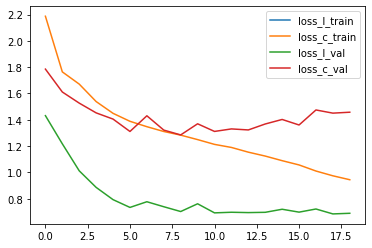

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loss_l_list_train, label='loss_l_train')
ax.plot(loss_c_list_train, label='loss_c_train')
ax.plot(loss_l_list_val, label='loss_l_val')
ax.plot(loss_c_list_val, label='loss_c_val')
plt.legend()

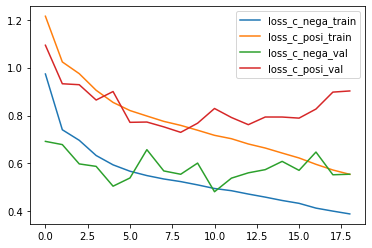

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loss_c_nega_list_train, label='loss_c_nega_train')
ax.plot(loss_c_posi_list_train, label='loss_c_posi_train')
ax.plot(loss_c_nega_list_val, label='loss_c_nega_val')
ax.plot(loss_c_posi_list_val, label='loss_c_posi_val')
plt.legend()